# Data Science Bootcamp project

## Libraries

In [125]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import chi2_contingency, mannwhitneyu
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from Functions import*

## Machine Learning

In [73]:
df_cardiovascular = pd.read_csv("Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset_cleaned.csv")

In [74]:
df = df_cardiovascular.copy()

As it has been studied along the Memory, our target is a feature with only two possible values: 1 - heart disease, 0 - no heart disease.

Therefore, we have to find the models that best fits with this type of targets. 

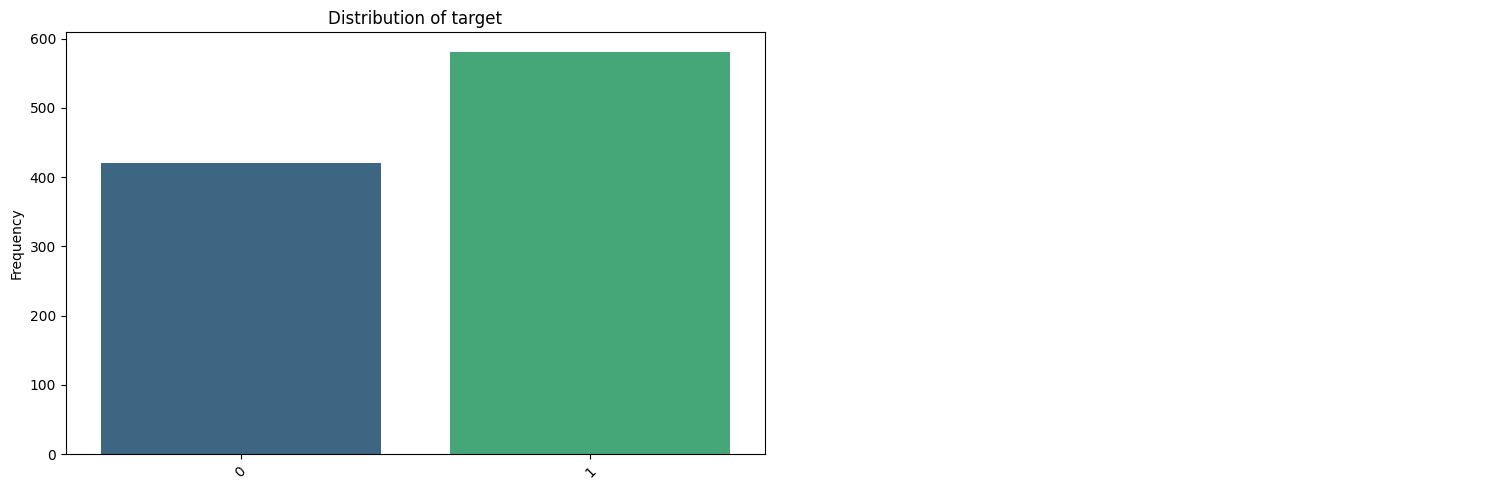

In [75]:
bt.pinta_distribucion_categoricas(df, ['target'], relativa=False, mostrar_valores=False)

### Load and preprocess data

After the previous analysis along the Memory, we should remove those columns that are not relevant with the target to reduce the feature numbers and simplify the model and improve the eficiency. 

In [76]:
df = df.drop(columns=['patientid', 'exerciseangia','age', 'gender','oldpeak'])

In [77]:
df.columns

Index(['chestpain', 'restingBP', 'serumcholestrol', 'fastingbloodsugar',
       'restingrelectro', 'maxheartrate', 'slope', 'noofmajorvessels',
       'target'],
      dtype='object')

Once we have made these changes, we can start with the steps to get the Machine Learning model.

In [78]:
X = df.drop(columns=['target'])
y = df['target']

### Division of the dataset

In [79]:
# Dividing the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


We have not normalized or standarized the numeric characteristics with the code below because this transformation will affect to all features although they are categorical, as all of them have numerical values. 

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Random Forest and XGBoost don't need the normalization, and Pipeline can work with this normalization better than other models.

### Train and Evaluate Three Models: Pipeline, Random Forest and XGBoost

First of all, we will work on these three, we will optimize all of them and later, compare which one of them is the best one. 

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

In [81]:
from sklearn.model_selection import train_test_split, learning_curve

In [83]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Searching the best hyperparameters 
param_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [1,5,10,None],
    "min_samples_leaf": [1,10,20,100],
    "class_weight": ["balanced",None],
    "max_features": ["sqrt","log2",None]
}

# Configuration of GridSearchCV
rf_grid = GridSearchCV(rf_model,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "balanced_accuracy")

# Training GridSearchCV
rf_grid.fit(X_train,y_train)

# Obtaining the best model found
best_rf_model = rf_grid.best_estimator_

# Printing the best hyperparameters 
print(f'Best hyperparameters: {rf_grid.best_params_}')

# Evaluate the best model in the test set 
y_pred_best = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        83
           1       1.00      0.98      0.99       117

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [84]:
# Defining XGBoost model 
xgb_model = XGBClassifier(random_state=42)

# Searching the best hyperparameters 
param_grid = {
    "n_estimators": [100, 200, 400],          
    "eta": [0.1, 0.3, 0.6, 1],                 
    "max_depth": [1, 6, 10, None],              
    "min_child_weight": [1, 10, 20, 100],       
    "scale_pos_weight": [len(y_train[y_train == 0])/len(y_train[y_train == 1]), 1], 
    "colsample_bytree": [0.5, 1]                
}

# Configuration of GridSearchCV
xgb_grid = GridSearchCV(estimator=xgb_model,
                        param_grid=param_grid,
                        cv=5,
                        scoring="balanced_accuracy")

# Training GridSearchCV
xgb_grid.fit(X_train, y_train)

# Obtaining the best model
best_xgb_model = xgb_grid.best_estimator_

# Printing the best hyperparameters 
print(f'Best hyperparameters: {xgb_grid.best_params_}')

# Evaluate the best model in the test set 
y_pred_xgb = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

Best hyperparameters: {'colsample_bytree': 0.5, 'eta': 0.6, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 0.7278617710583153}
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        83
           1       0.98      0.97      0.97       117

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



The second set of hyperparameters shows an overall improved performance in terms of precision, recall, F1-score, and accuracy compared to the first. Specifically, the second model has a higher F1-score for both classes, indicating a better balance between precision and recall. Precision and recall for class 1 in the second model are perfect (1.00 and 0.97 respectively), suggesting excellent identification of that class by the model. 

In summary, the second set of hyperparameters appears to be more effective for this specific classification problem, as it produces superior evaluation metrics compared to the first.

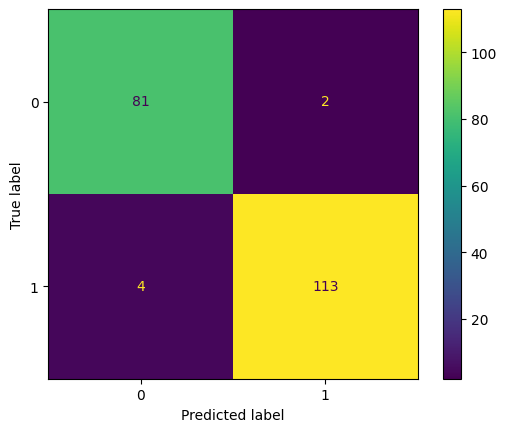

In [85]:
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test)
plt.show()

ROC AUC: 0.9988672639275049


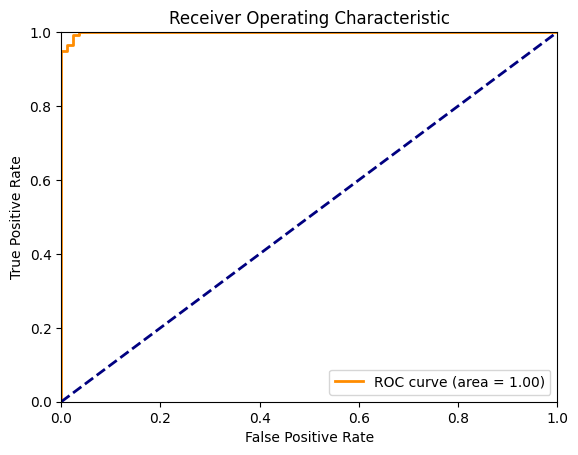

In [86]:
# Calculation of AUC-ROC
y_prob = best_xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC: {roc_auc}')

# Plot of the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve is very high. This means that the model has a very high capacity to differentiate between the classes. The closer the AUC is to 1, the better the model's performance in terms of discrimination.

The binary classification model performs exceptionally well, with a high capacity for class differentiation (AUC-ROC) and strong balance between precision and recall in both classes, reflected in high f1-score and accuracy values. This suggests the model is suitable for applications where both precision and recall are important.

### Overfitting in Model

We will use the cross-validation to check the model's performance across different data splits.
The idea is to observe if there is significant variation in performance among different partitions (folds); inconsistent performance across folds could indicate overfitting.

Generally, it is recommended to use at least 5 or 10 folds to evaluate the model robustly. In this case, we will use 20 as the ROC AUC is close to 1 and we will need to ensure that there is no overfitting.

In [87]:
#Defining the cross-validation scheme
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# Applying cross-validation and obtaining scores of precision
scores = cross_val_score(best_xgb_model, X, y, cv=cv, scoring='accuracy')

# Printing the results
print(f'Cross Validation Scores: {scores}')
print(f'Mean Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')


Cross Validation Scores: [1.   0.96 0.98 1.   0.94 1.   0.96 0.98 0.92 0.96 0.94 1.   0.96 0.92
 0.96 0.98 1.   0.96 1.   1.  ]
Mean Accuracy: 0.9710 +/- 0.0264


This indicates that the model performs well overall, with an average accuracy of 97.10%. The small standard deviation suggests consistent cross-validation results across folds, which is positive for model evaluation.

Other way to detect if there is overfitting is visualizing the learning curves of the model by comparing performance on the training set and the validation set as the training set size increases.

In [96]:
# Función para graficar las curvas de aprendizaje
def plot_learning_curve(model, X_train, y_train, X_test, y_test):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve (Logistic Regression)")
    plt.xlabel("Number of Training examples")
    plt.ylabel("Accuracy")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation")

    plt.legend(loc="best")
    plt.show()

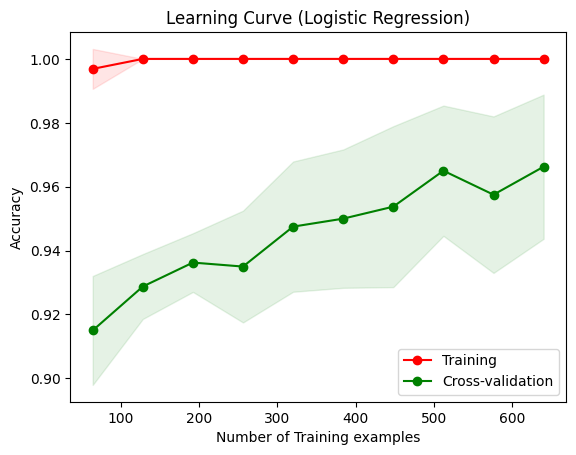

In [97]:
plot_learning_curve(best_xgb_model, X_train, y_train, X_test, y_test)

We can see that the gap between training and validation performance is decreasing as the training set size increases, so it could indicate that there's no overfitting.

### Final Model

After all the analysis made to find the best model, we have found that our current model is really good obtaining values and results. 

We have seen that the results obtained with the training/testing split show consistently high metrics such as precision, recall, and F1-score, it suggests that the model is generalizing well. 

In such cases, there may be no need to retrain the model with the entire dataset, because training the model with the entire dataset may yield a slightly different model due to the increased amount of data. 

In [89]:
best_xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.6, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

We will obtain the characteristics importance:

In [90]:
booster = best_xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')

In [91]:
# Sorting the characteristics
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

In [92]:
import xgboost as xgb

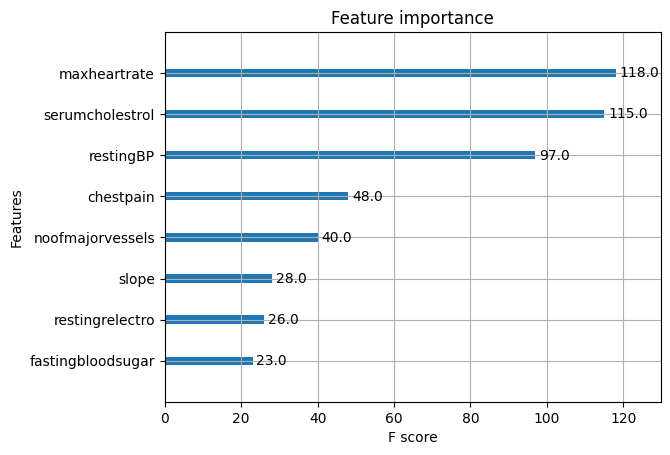

In [93]:
xgb.plot_importance(best_xgb_model, importance_type='weight')
plt.show()

maxheartrate, serumcholestrol and restingBP are the features that affects in the target the most. 

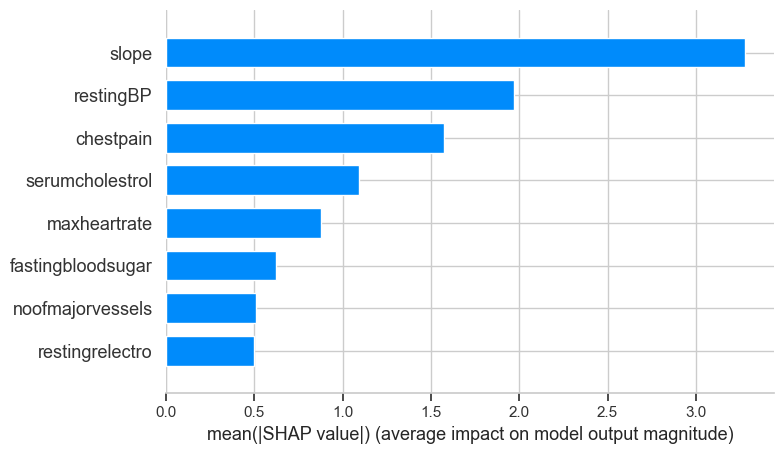

In [156]:
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test)

# Visualizar los valores SHAP
#shap.summary_plot(shap_values, input_data)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

### Application

Now, we are going to apply to our model many values to calculate if we have a risk to have heart disease or not and some recommendations.

In [168]:
data = {
    'chestpain': [0],
    'restingBP': [100],  
    'serumcholestrol': [300],  
    'fastingbloodsugar': [0], 
    'restingrelectro': [1],  
    'maxheartrate': [200],  
    'slope': [2],  
    'noofmajorvessels': [1],  
 
}

C:\Users\rjulianortin\AppData\Local\Temp\ipykernel_59796\801701704.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels, y=prob_values, palette=colors)


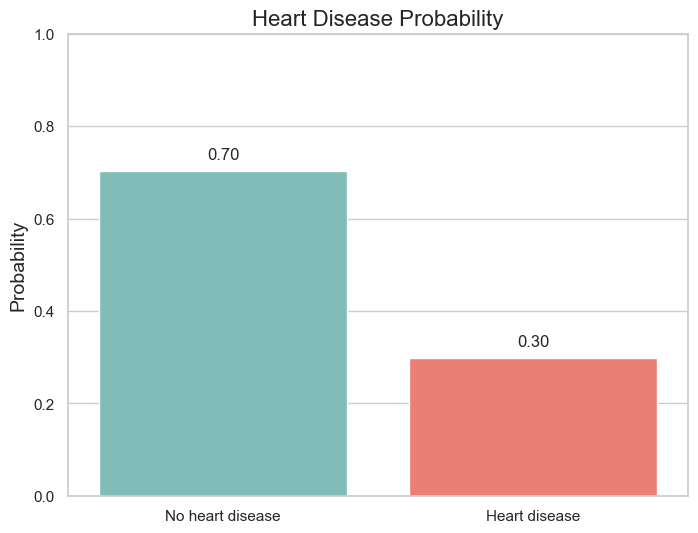

Based on your profile, here are some recommendations to improve your health:
- Chest pain type 0 indicates typical angina. Consider a medical evaluation to determine the cause.
- High serum cholesterol levels may increase the risk of heart disease. Switch to a low-cholesterol diet and consult a physician.
- Abnormalities in the electrocardiogram may indicate heart issues. Additional tests are recommended to assess heart health.
- Your maximum heart rate is high. Consider a cardiovascular evaluation and adjust your exercise regimen accordingly.


In [169]:
analyze_health(data, best_xgb_model)

Finally, we will store the model in pickle file.

In [109]:
with open('predictor_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)